# CIS-522 Week 6 Homework

__Instructor__: Konrad Kording

__Content creators:__ Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava


In this homework, you will implement image classification problem on a much more complex Dataset, the **CIFAR 10 Dataset**. We will train two models a fully connected network and a Convolutional Neural Network and observe the differences in their performance on images. Further, we will also try to visualize the features learn by some of our Convolutional layers in CNN and answer some questions about ethics and our pod members!

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'jabrantl' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


In [ ]:
# @title Run this cell for imports.

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# imports
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

In [ ]:
# @markdown Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


In [ ]:
#@markdown Device Settings<br> It should print 'cuda', if not change your runtime to GPU.
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Part 0. Exploring the Dataset and Basic Functions





The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes in the dataset are:<br>
['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let us download the dataset, and build our datatloaders. Set the **BATCH_SIZE** for the dataloaders yourself. 

The three dataloaders are accessible by the variables *trainloader*, *validationloader* and *testloader*. 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# TODO: set Batch size for dataloaders
BATCH_SIZE = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# splitting the testset into testset and validationset, with a 80:20 ratio
validationset, testset = torch.utils.data.random_split(testset, [8000, 2000])

validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Let us check the sizes of our three sets and print some images. 

In [ ]:
print(len(trainset))
print(len(validationset))
print(len(testset))

50000
8000
2000


torch.Size([64, 3, 32, 32])


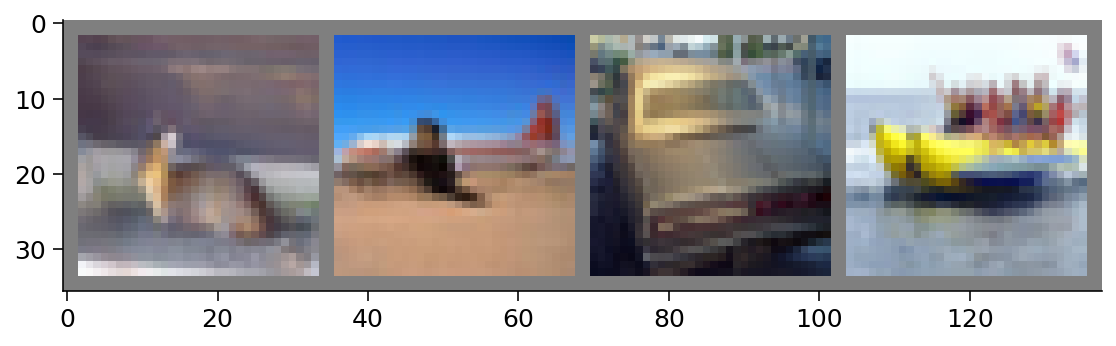

 deer    		plane    		  car    		 ship


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

imshow(torchvision.utils.make_grid(images[0:4]))
print('    \t\t'.join('%5s' % classes[labels[j]] for j in range(4)))

Now let us write a train function which basically trains any network by running epochs and also evaluates the results on our validation set in every epoch. We will keep tunable hyperparameters as the parameters for the function, so that we can directly tweak them and call the function. 

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
  # Params:
  #   model-> instance of your model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   train_loader -> dataloader for train dataset, already stored in a variable called *trainloader*
  #   validation_loader -> dataloader for validation dataset, already stored in a variable called *validationloader*
  #   epochs -> number of epochs for training, you are expected to experiment and play around with this
  #   criterion -> the loss function which you decide to use
  #   optimizer -> optimizer for your gradient descent, do not forget to set an appropriate learning rate
  #  Returns:  train_loss, train_accuracy, validation_loss, validation_accuracy, all of these are lists storing the values 

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        # TODO: train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)

                # COMPLETE CODE FOR TRAINING LOOOP
                # 2. Zero the gradients out
                optimizer.zero_grad()

                # 1. Get the model output
                output = model(data)

                # 3. Get the Loss
                loss = criterion(output,target)

                # 4. Calculate the gradients
                loss.backward() 

                # 5. Update the weights
                optimizer.step()
                
                # Set the loss
                tepoch.set_postfix(loss=loss.item())
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append the loss
        train_loss.append(loss)  # append the loss for this epoch
        train_acc.append(correct/total)
                
    
        # TODO: evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    
    return train_loss, train_acc, validation_loss, validation_acc 

Now, let us write a test function, which returns the accuracy of a trained model on the testdataset, given the testloader. 


In [ ]:
def test(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   accuracy(float)-> percentage of correct predictions made by your trained model
    model.eval()
    correct = 0
    total = 0
    confusion_matrix = torch.zeros(10,10)
    false_negative = torch.zeros(10,2)

    for data in data_loader:
        # TODO: fill in the test function
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                # if t == p:
                #     print('yup')

    acc = 100 * correct / total
    
    return acc, confusion_matrix

Below, we have provided a function to plot your train loss, test loss, train accuracy and test accuracy, during the training process. They take in arguments, which were the four lists returned by your train function. 

In [ ]:
# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


# Part 1: FeedForward Neural Network

In this section, we will implement a Feed forward Neural Network that can classify the images in the CIFAR 10 dataset. 

Here, we define our FFN class which will consists of all the layers and the forward function. Feel free to play around by introducing different types of regularization, architectures, learning rates, epochs, and batch sizes, in order to achieve maximum accuracy, except the constraint that do not use convolutional layers in the model. 

## Architecture

In [ ]:
class FFN(nn.Module):
  def __init__(self):       
    super(FFN, self).__init__()
    # TODO: fill in the layers
    self.fc1 = nn.Linear(3*32*32, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output



## Training

Now, let us intantiate our FFN class, define the loss, the optimizer and call the train function. 

In [ ]:
# TODO: set criterion, optimizer and other hyperparameters and train
net1 = FFN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(),lr=1e-4,weight_decay=0.0001)
num_epochs = 15
train_loss, train_acc, validation_loss, validation_acc = train(net1, device, trainloader, validationloader, num_epochs, criterion, optimizer)

## Training Plots

Now, let us plot the train and validation curves. 

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

NameError: ignored

Take a screenshot of your Training Curves (Both Accuracy and Loss) and submit it in the AirTable Form at the end of the Worksheet.

## Test Accuracy

And test our trained network on the test set. 

In [ ]:
test(net1, device, testloader)

55.6

And fill up the accuracy value you get. 

In [ ]:
ffn_accuracy = '''55.6'''

Try to reach a test accuracy of atleast 45% with the Fully Connected Network. Try for even more!

You may try different models and variations and then submit the results (training curves) and the accuracy of your best model.

## Discuss



In [ ]:
#@markdown Now, discuss the hyperparameters and architectures you chose. Which model led to the best performance? Why? (200 words)
import time
try:t1;
except NameError: t1 = time.time()

In [ ]:
ffn_discussion = '''
1. self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 32)
   self.fc3 = nn.Linear(32, 10)
   lr = 1e-4
   weight_decay = 0.1
   
   * Accuracy ~ 30%

2. self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 32)
   self.fc3 = nn.Linear(32, 10)
   lr = 1e-4
   weight_decay = 0.1 --> 0.01
   epoch = 10

  * Accuracy ~ 45%

3. self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 32)
   self.fc3 = nn.Linear(32, 10)
   lr = 1e-4
   weight_decay = 0.01 --> 0.001
   epoch = 10
  
   * Accuracy ~ 50%

4. self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 32)
   self.fc3 = nn.Linear(32, 10)
   lr = 1e-4
   weight_decay = 0.001 -->  0.0001
   epoch = 10

   * Accuracy ~ 51%

5. self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 32)
   self.fc3 = nn.Linear(32, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 10 --> 20
   
   * Accuracy ~ 52%

6. change hidden layer 2-->3 from 32 --> 64
   self.fc1 = nn.Linear(3*32*32, 128)
   self.fc2 = nn.Linear(128, 64)
   self.fc3 = nn.Linear(64, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 20 --> 10
   
   * Accuracy ~ 52%

7. change layer 1-->2 from 128 --> 512
   self.fc1 = nn.Linear(3*32*32, 512)
   self.fc2 = nn.Linear(512, 64)
   self.fc3 = nn.Linear(64, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 10
   
   * Accuracy ~ 54%

8. self.fc1 = nn.Linear(3*32*32, 512)
   self.fc2 = nn.Linear(512, 64)
   self.fc3 = nn.Linear(64, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 10
   change batch from 64 --> 128
   
   * Accuracy ~ 54%

9. self.fc1 = nn.Linear(3*32*32, 512)
   self.fc2 = nn.Linear(512, 64)
   self.fc3 = nn.Linear(64, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 10 --> 20
   change batch from 128 --> 64
   
   * Accuracy ~ 55%
   ** Looks like valid loss starts to increase around 15 epochs

10. self.fc1 = nn.Linear(3*32*32, 512)
   self.fc2 = nn.Linear(512, 64)
   self.fc3 = nn.Linear(64, 10)
   lr = 1e-4
   weight_decay = 0.0001
   epoch = 20 --> 15
   change batch from 128 --> 64
   
   * Accuracy ~ 55%


After 10 different model variations, the final test accuracy was ~55%. The first attempt was to
start with a relatively simple and shallow model. The next step was to change the regularization
in the optimizer by changing weight_decay. After observing that smaller values continued to decrease
the loss and improve accuracy, the next change was in the num_epochs, which indeed did improve 
accuracy. The next step was the increase the number of nodes in the two layers in between the 
input and output layer. This also improved performance. Finally, changing the batch size did not seem to have
an effect on my chosen model. I observed that the validation loss began to increase if too many epochs were used
so the training was run for 15 epochs to prevent memorization.
'''

# Part 2: Convolutional Neural Network

Now, design a Convolutional Neural Network, for the same problem. Again, try to play around with various architectures, regularizations, activations, learning rates, optmizers and try to leverage the power of CNNs!

**Note:** Put all your Convolutional layers, activations in the first Sequential module, instead of defninig different layers and making an explicit forward pass.
Similarly, add all the subsequent fully connected layers in the second Sequential module, which comes after flattening the output from the convolutional layers.

**Do not change the forward pass code here.** 
<br>
This will help you run the next section on Visualization on your chosen architecture and visualize the feature maps of different convolutional layers. 

## Architecture

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(6272, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128,10)
        )

        
    # DO NOT CHANGE THE FORWARD PASS
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        output=self.fc(x)
        return output

## Training

Calling the train function for the ConvNet.

In [ ]:
# TODO: fill the hyperparameters and train the model
net2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(),
                              lr=0.01, momentum=0.9,weight_decay=0.001)
num_epochs = 10
train_loss, train_acc, validation_loss, validation_acc = train(net2, device, trainloader, validationloader, num_epochs, criterion, optimizer)

## Training Plots

Now plot your training curves!

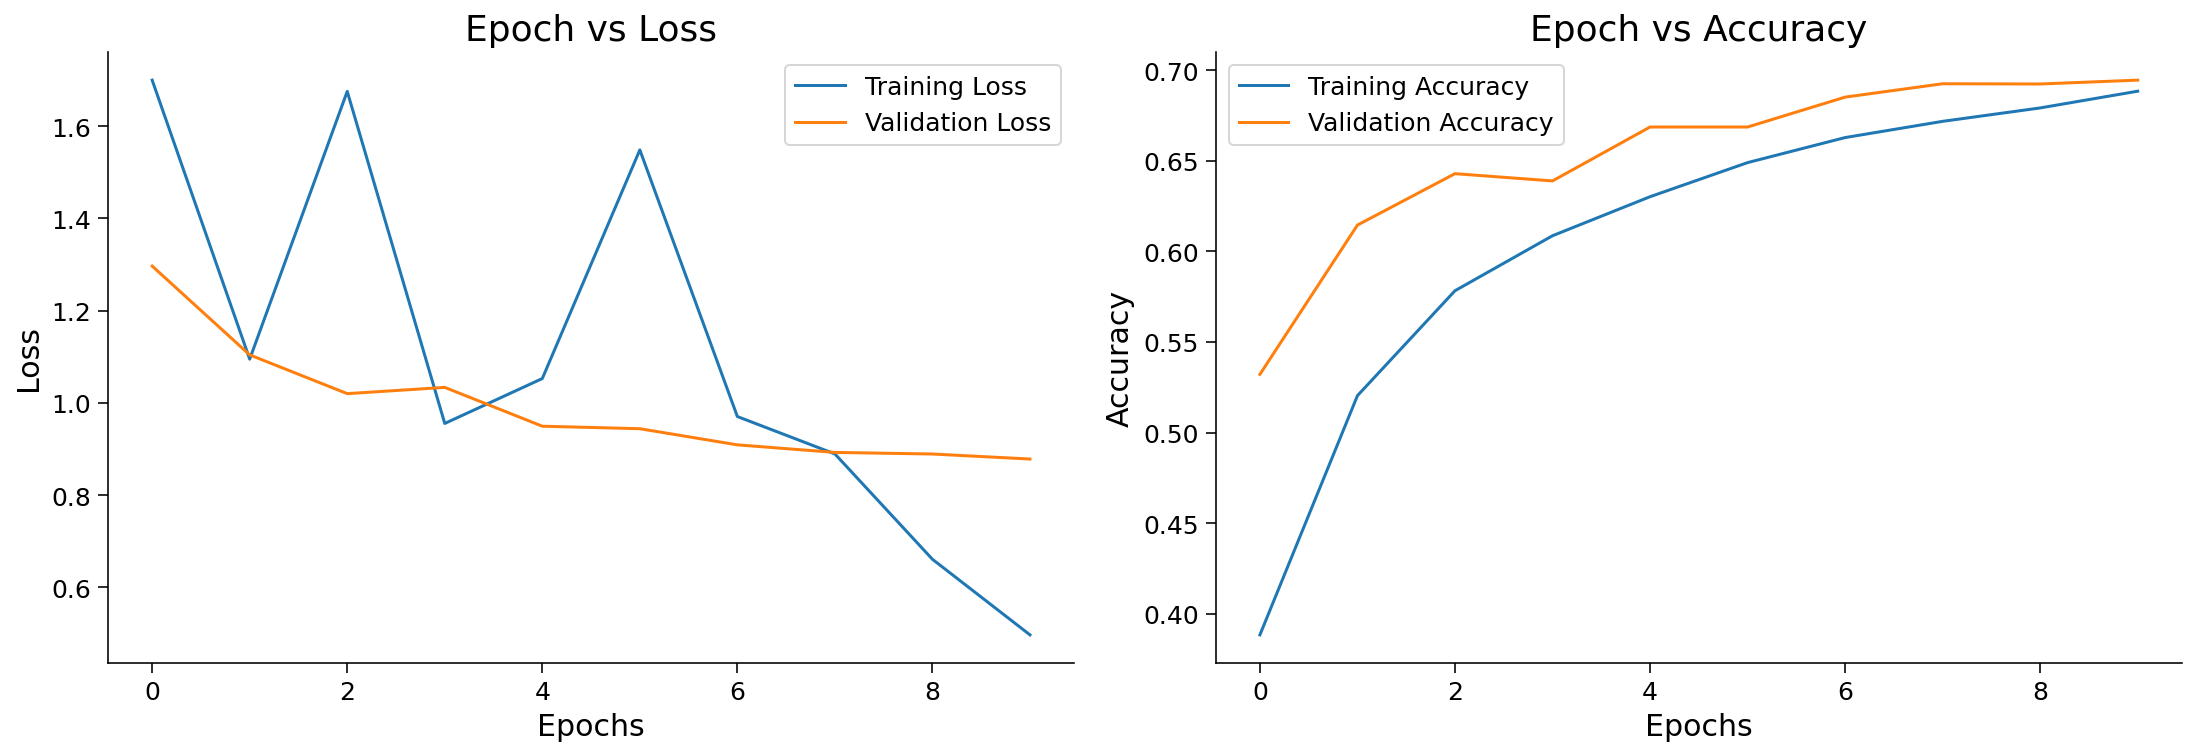

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## Test Accuracy

And, test your trained model on the Test Dataset. 

In [ ]:
cnn_acc, cnn_confmat = test(net2, device, testloader)

yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup


And, fill up the accuracy here.

In [ ]:
cnn_accuracy = '''71.65 %'''

Try to reach an accuracy of atleast 52%.Of course try to get your test accuracy even higher, and leverage the true powers of CNNs!

## Discussion

In [ ]:
#@markdown Discuss the hyperparameters and architectures you chose. Which model led to the best performance? Did your CNN outperform your FFN? Why? (200 words)
import time
try:t2;
except NameError: t2 = time.time()

In [ ]:
cnn_discussion = '''
I chose to use two conv layers and two linear layers. The conv layers were both output_channels=32 with kernel=3 and stride=1. Each was
followed by batch normalization and a ReLU. Both of these layers have the effect of halving the input height and width at each layer, so the image size goes from
32x32 --> 16x16 --> 8x8. After the second ReLU, I applied a Maxpool layer and dropout at 50%. This was followed by flattening, then a linear layer 
that matched the dims after the last conv-->batch_norm-->relu-->maxpool. This resulted in a layer size of over 6k that was then reduced to 128 then 10 for the ouput prediction. 

The CNN outperformed the FCN by approximately 20% improvement. The learned kernels that are applied in the conv layers are better able to extract the meaningful features in the image and the maxpool layers assist with invariance. 
'''

# Part 3: Visualizations: What do the features look like?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


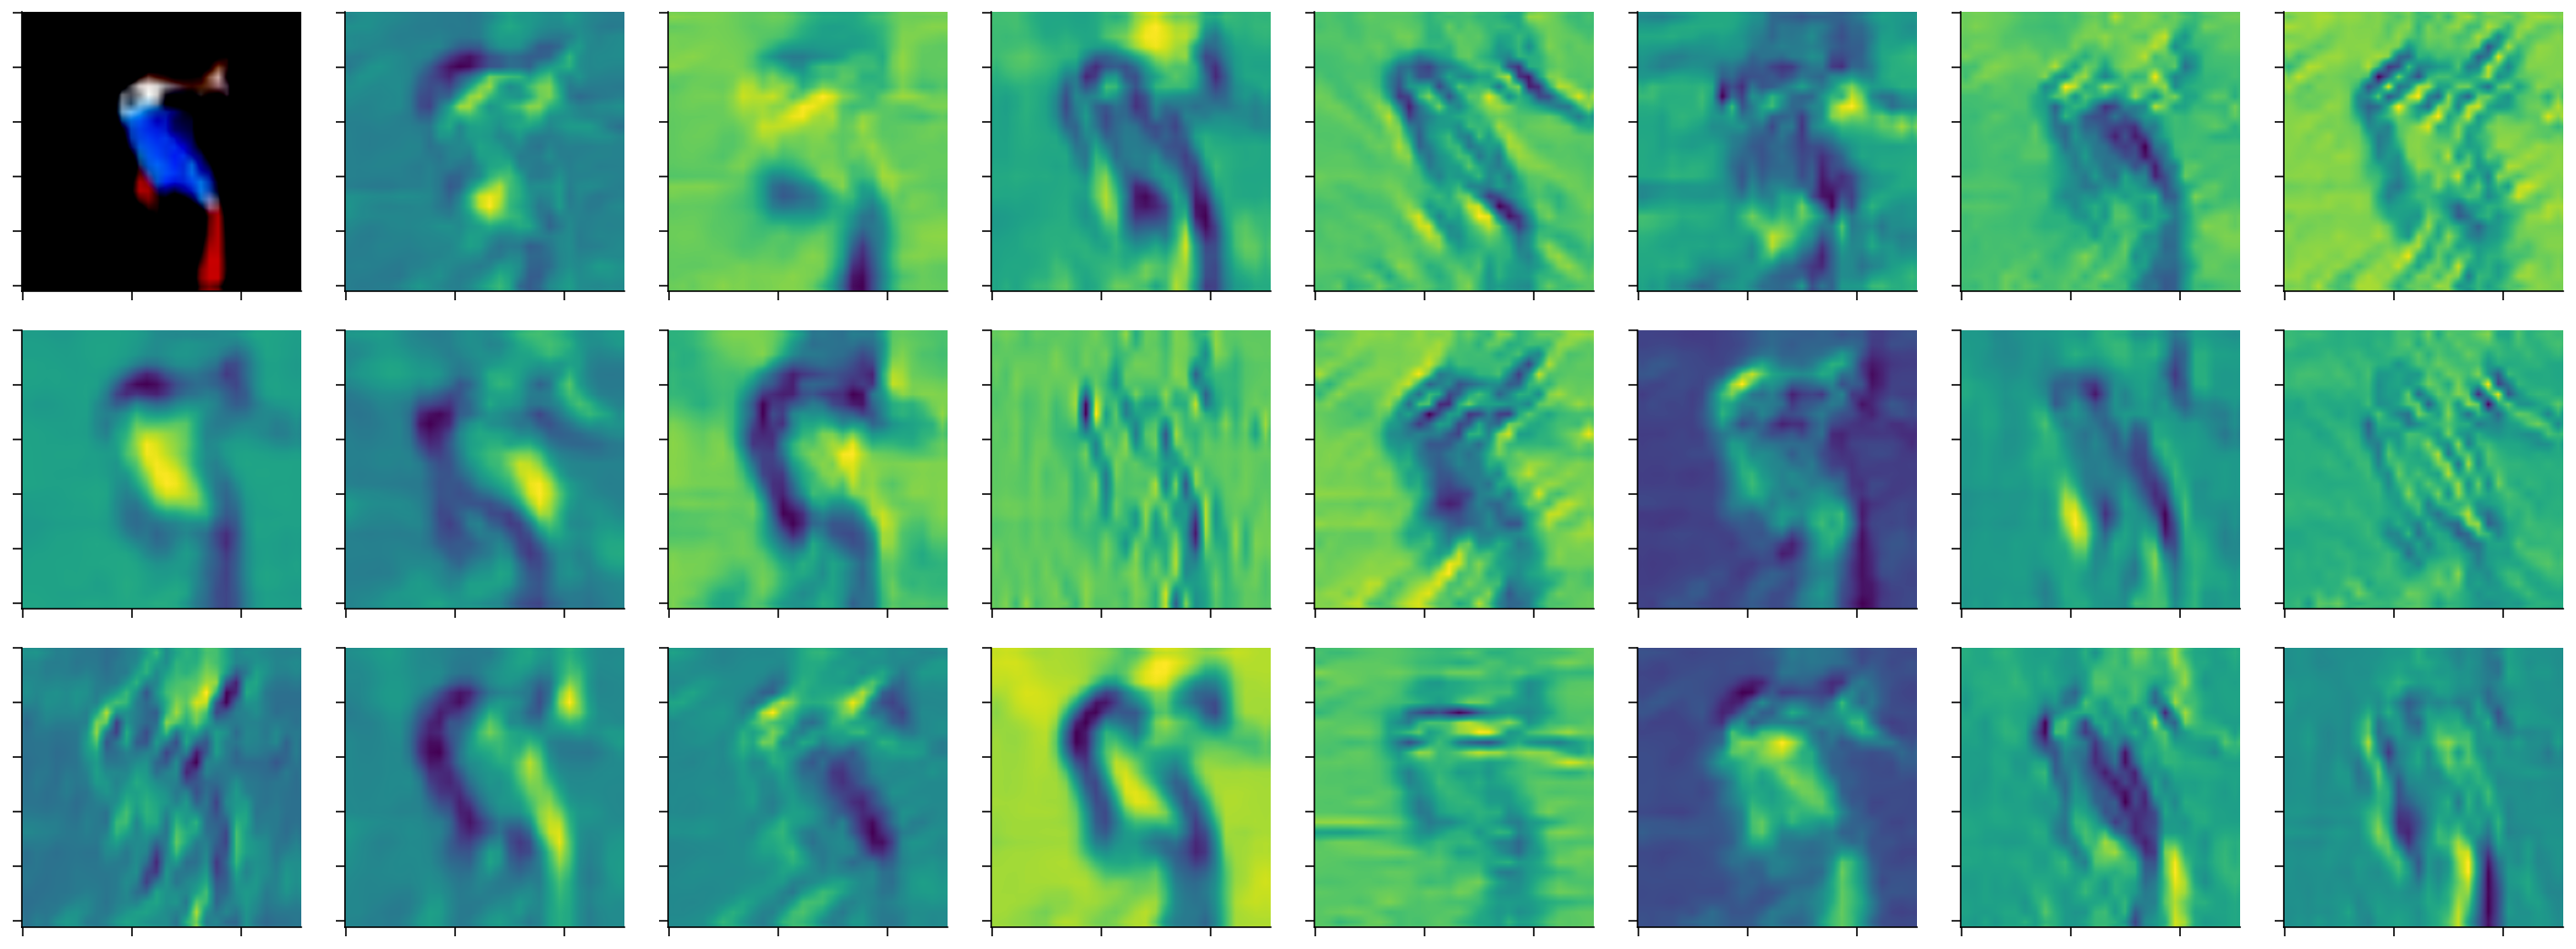

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
input_img=images[random.randrange(0,BATCH_SIZE,1)].unsqueeze(0)
img_original=input_img.squeeze().permute(1,2,0).numpy()


Layer_Name= 3 #@param {type:"slider", min:1, max:54, step:1}
Layer_Name=str(Layer_Name)
Num_Filters = 29 #@param {type:"slider", min:1, max:64, step:1}
from skimage.transform import resize
import matplotlib.pyplot as plt
def temp_rem(model,key,input_img):
    model.eval()
    flag=0
    alt_=[]    
    for search in model._modules['features']._modules.keys():
        if flag==1:
            break
        if key==search:
            flag=1
        alt_.append(model._modules['features']._modules[search])
    return torch.nn.Sequential(*alt_).to(device)(input_img.to(device)).squeeze().detach().cpu().numpy()

def plot(data,Num_Filters,img_original):
    import matplotlib.pyplot as plt
    i=0
    flag=0
    #print(len(data))
    if Num_Filters>len(data):
        print("Please set Num_Filters parameter less than or equal to the number of filters present in the layer ({} in this case)".format(len(data)))
        return
    if Num_Filters<8:
        fig, ax = plt.subplots(1,Num_Filters)
        for col in ax:
            if flag==0:
                col.imshow(resize(img_original,(256,256)))    
                col.set_xticklabels([])
                col.set_yticklabels([])
                
                flag=1
            else:
                col.imshow(resize(data[i],(256,256)))
                col.set_xticklabels([])
                col.set_yticklabels([])
                
            i=i+1
        
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        return

    i=0    
    if Num_Filters<16:
        ncols=4
    else:
        ncols=8

    nrows=Num_Filters//ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    for rows in ax:
        for cols in rows:
            if flag==0:
                cols.imshow(resize(img_original,(256,256)))    
                cols.set_xticklabels([])
                cols.set_yticklabels([])
                flag=1
            else:
                cols.imshow(resize(data[i],(256,256)))
                cols.set_xticklabels([])
                cols.set_yticklabels([])
                
            i=i+1
        
        
    fig.set_size_inches(ncols*2.5,nrows*2.5)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

model = net2
plot(temp_rem(model,Layer_Name,input_img),Num_Filters,img_original)

## Discussion

 Describe some of the convolutional feature maps for certain images. What do you think they are representing? Do deeper convolutions result in different feature representations? (200 words)


In [ ]:
#@markdown Describe some of the convolutional feature maps for certain images. What do you think they are representing? Do deeper convolutions result in different feature representations? (200 words)
import time
try:t3;
except NameError: t3 = time.time()

In [ ]:
visualization_discuss = '''
It seems that for most images, there are clearly some that are for edge detection while others are for more complex features, like colors, textures, and patterns.
It seems that there is a trend for deeper features to be more complex, but in many cases, the feature representations in the middle look more complex than the beginning, which look
more like edges. 

'''

# Part 4: Deep Learning, Deep Thinking


## Part 4.1

Okay, so you all just solved a classification task using the CIFAR Dataset. Before we move ahead, please read the following to articles. 
 https://excavating.ai/ and https://medium.com/analytics-vidhya/an-introduction-to-fairness-in-machine-learning-62ef827e0020 (explains the fundamentals of measuring fairness in machine learning models).
 
 
<br><br> 
What do these readings suggest? There may be problems with unbalanced data and biases present in data. Now, go back and reflect on what you just did. Did you consider these problems when you designed your convnet? Write your thoughts (about 100 words).

In [ ]:
bias_response = '''
Clearly, ML models struggle with bias. Historically, this was a concern when hand-selected
features were extracted by the individual crafting the model. However, even with DL methods,
choice of training data and architecture can lead to variations in model bias. 
One of the biggest problems with many of the unfair models is the training data. In many cases,
these images were labeled by humans that thus already contain the biases held by the person
labeling them. 

In our predictions, we chose the architecture and although we do not have a choice of what features we extract,
we have some control over how much we are able to see and understand based on the number of layers and receptive field. 
It is not clear if we specified that we want equal number of instances from each class, which 
can seriously impact the model bias. 

'''

Now, its time to see what those implications are on the models you just trained. <br>

**[Optional]**<br>



> Report the results of the independence and separation criteria you just read about in the medium article i.e report the accuracy for each class (independence) and report the false positive and false negative for each class (separation). <br>You can write separate code for implementing this. 
<br>
Submit a screenshot of your results in the AirTable Form at the end. (Do not worry about the format, it should be interpretable and readable)




0.7


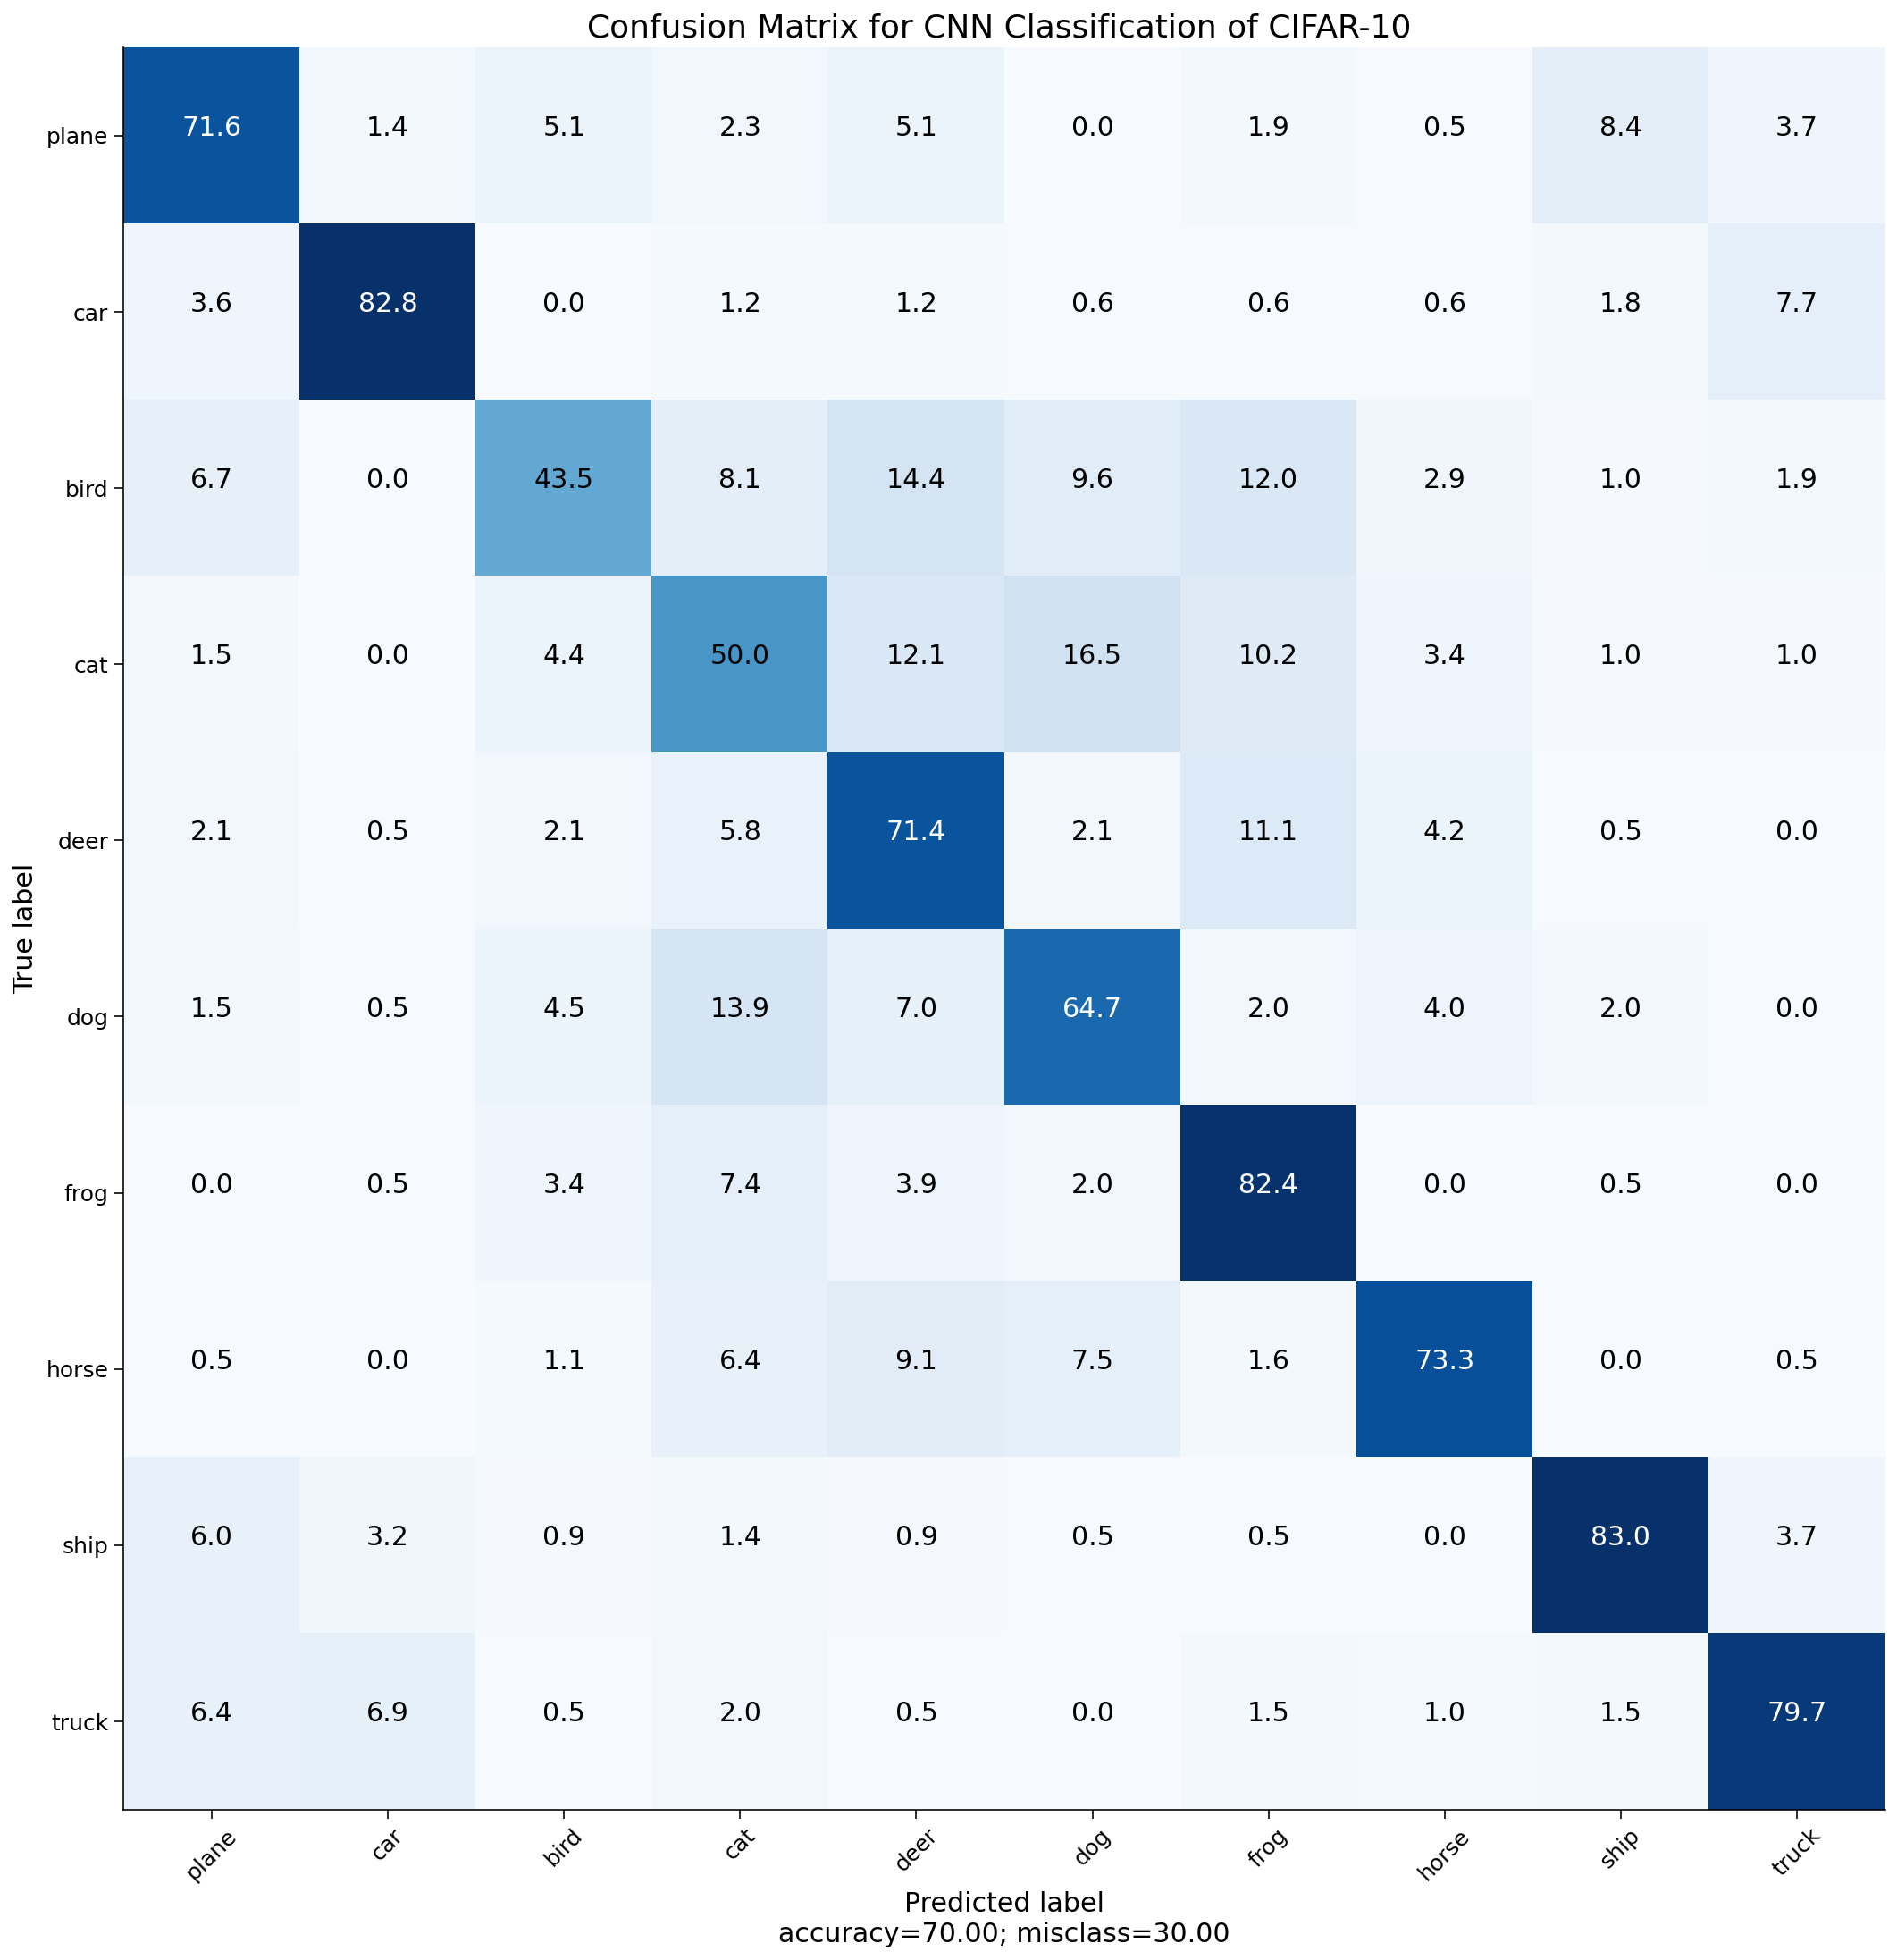

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import itertools

# Get accuracy
accuracy = np.trace(cnn_confmat.numpy()) / float(np.sum(cnn_confmat.numpy()))
print(accuracy)

misclass = 1 - accuracy

cm = cnn_confmat.numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Colormap
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(15,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix for CNN Classification of CIFAR-10 ')
#plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



normalize = 1
thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:.1f}".format(100*cm[i, j]),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:.2f}; misclass={:.2f}'.format(accuracy*100, misclass*100))
plt.show()


In [ ]:
for data in testset:
    inputs, labels = data
    outputs = model(inputs)

RuntimeError: ignored

## Part 4.2

Let’s take a step back and consider the following questions 

1.   why might data be biased or imbalanced in the first place? Who gets to determine the labels of these data, and what might be some ethical concerns here?
2.   what are ethical implications of not investigating the data beforehand? Give a concrete example of some strategies to mitigate this.
<br><br>
Post your thoughts on your pods slacks channel and have a discussion amongst your pod members.

# Part 5: Better Know a Pod

Discuss with two other members of your pod. What is something they've always wanted to learn but have never gotten the chance to? (~100 words each)

In [ ]:
#@markdown Discuss with two other members of your pod. What is something they've always wanted to learn but have never gotten the chance to? (~100 words each)
import time
try:t4;
except NameError: t4 = time.time()

In [ ]:
know_a_pod_1 = '''
  Nicole Chiou: She wishes she were a better dancer and would have spent more time learning to dance.
'''

In [ ]:
know_a_pod_2 = '''
  Jackie Peng: She wishes she learned more languages.
'''

# Submit your responses
Please run the following cell and then press "Submit" so we can record your responses.

In [ ]:

#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers, upload your screenshots, paste the notebook link and then click "Submit"**

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: ffn_accuracy;
except NameError: ffn_accuracy = ""

try: ffn_discussion;
except NameError: ffn_discussion = ""

try: cnn_accuracy;
except NameError: cnn_accuracy = ""

try: cnn_discussion;
except NameError: cnn_discussion = ""

try: visualization_discuss;
except NameError: visualization_discuss = ""

try: know_a_pod_1;
except NameError: know_a_pod_1 = ""

try: know_a_pod_2;
except NameError: know_a_pod_2 = ""

try: bias_response;
except NameError: bias_response = ""

times = np.array([t1, t2,t3,t4])-t0

fields = {"my_pennkey": my_pennkey,
          "my_pod": my_pod,
          "ffn_accuracy":ffn_accuracy,
          "ffn_discussion": ffn_discussion,
          "cnn_accuracy": cnn_accuracy,
          "cnn_discussion": cnn_discussion,
          "visualization_discuss":visualization_discuss,
          "know_a_pod_1":know_a_pod_1,
          "know_a_pod_2":know_a_pod_2,
          "bias_response":bias_response,
          "cumulative_times": times}

src = "https://airtable.com/shrp0bcg2kvnLqKDN"
#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)




        #     # TODO: fill the convolutional layers
        #     nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Dropout(0.25)
        # )

        # self.fc = nn.Sequential(
        #     # TODO: fill the fully connected layers that follow the conv module
        #     nn.Linear(9216, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(128, 10),
        #  )
        # Conv Layer block 1
            # Input image tensor is batch_size*3*32*32
            # nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
            # # Output dims: (32 - 3 +2*1)/1 + 1 = 32
            # # Image tensor is batch_size*32*32*32
            
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # # Output dims: (32 - 3 +2*1)/1 + 1 = 32
            # # Image tensor is batch_size*64*32*32
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # Output dims: (32 + 2*0 - 1*(2-1)  -1)/2 + 1 = (32 -2)/2 + 1 = 16
            # Image tensor is batch_size*64*16*16

            # # Conv Layer block 2
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(p=0.05),

            # # Conv Layer block 3
            # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc = nn.Sequential(
            nn.Linear(12544, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128,10)



            # nn.Dropout(p=0.1),
            # nn.Linear(4096, 1024),
            # nn.ReLU(inplace=True),
            # nn.Linear(1024, 512),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=0.1),
            # nn.Linear(512, 10)
        )

        
    # DO NOT CHANGE THE FORWARD PASS
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output=self.fc(x)
        return output